<a href="https://colab.research.google.com/github/fanaev/tadimo-labs/blob/main/blank_03_autograd_optim_nn_datasets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import numpy as np
import plotly.express as px
import plotly.graph_objects as go

In [ ]:
v = torch.ones(10,2, dtype=torch.float32)
print(v)

tensor([[1., 1.],
        [1., 1.],
        [1., 1.],
        [1., 1.],
        [1., 1.],
        [1., 1.],
        [1., 1.],
        [1., 1.],
        [1., 1.],
        [1., 1.]])


## 3.1 Автоматическое дифференцирование в `torch`

3.1.1 Воспользовавшись классами `Neuron` и `SquaredLoss` из задачи 2.4.1 и автоматическим дифференцированием, которое предоставляет `torch`, решить задачу регрессии. Для оптимизации использовать стохастический градиетный спуск.

In [ ]:
from sklearn.datasets import make_regression

X, y, coef = make_regression(n_features=4, n_informative=4, coef=True, bias=0.5)
X = torch.from_numpy(X).to(dtype=torch.float32)
y = torch.from_numpy(y).to(dtype=torch.float32)

In [ ]:
class Neuron:
  def __init__(self, n_inputs):
    self.weights = torch.randn(size = [n_inputs, 1], requires_grad = True)
    self.bias = torch.randn(size = [1,1], requires_grad = True)
  def forward(self, inputs):
    self.inputs = inputs
    self.output = self.bias + inputs @ self.weights
    return self.output 
  
  def backward(self):
    self.output.backward() 


In [ ]:
class SquaredLoss:
  def forward(self, y_pred, y_true):
    self.loss = torch.sum((y_pred - y_true)**2)
    return self.loss

  def backward(self):
    self.loss.backward()

In [ ]:
neuron = Neuron(4)
loss = SquaredLoss()
lr = 1e-1
losses = []
for epoch in range(10):
      for x_example, y_example in zip(X, y):
       y_pred = neuron.forward(x_example) # <прогон через нейрон>
       curr_loss = loss.forward(y_pred, y_example)# <прогон через функцию потерь>
       losses.append(curr_loss.detach().numpy())

       # backprop
       # <вызов методов backward>
       loss.backward()
       # обратите внимание на последовательность вызовов: от конца к началу

       # <шаг оптимизации для весов (weights и bias) нейрона>
       with torch.no_grad():
        neuron.weights -= lr * neuron.weights.grad
        neuron.bias -= neuron.bias.grad * lr
       neuron.weights.grad.zero_()
       neuron.bias.grad.zero_()

In [ ]:
px.line(losses)

3.1.2 Воспользовавшись классами `Linear` и `MSELoss` из задачи 2.1.4 и 2.3.1, `ReLU` из 2.2.1 и автоматическим дифференцированием, которое предоставляет `torch`, решить задачу регрессии. Для оптимизации использовать пакетный градиентный спуск. Вывести график функции потерь в зависимости от номера эпохи. Вывести на одном графике исходные данные и предсказанные значения.

In [ ]:
X = torch.linspace(0, 1, 100).view(-1, 1)
y = torch.sin(2 * np.pi * X) + 0.1 * torch.rand(X.size()) 

In [ ]:
class Linear:
  def __init__(self, n_features, n_neurons):
    self.weights = torch.randn(size = [n_features, n_neurons], requires_grad = True)
    self.bias = torch.randn(size = [1, n_neurons], requires_grad = True)
  def forward(self, inputs):
    self.inputs = inputs
    self.output = inputs @ self.weights + self.bias
    return self.output

  def backward(self):
    self.output.backward()


In [ ]:
class MSELoss:
  def forward(self, y_pred, y_true):
    self.loss = torch.mean((y_pred - y_true)**2)
    return self.loss

  def backward(self):
    self.loss.backward()

In [ ]:
neuron = Linear(1, 1)
loss = MSELoss()
lr = 1e-3
epo_losses = []
for epoch in range(100):
      losses = []
      for x_example, y_example in zip(X, y):
       y_pred = neuron.forward(x_example) # <прогон через нейрон>
       curr_loss = loss.forward(y_pred, y_example)# <прогон через функцию потерь>
       losses.append(curr_loss.detach().numpy())

       # backprop
       # <вызов методов backward>
       loss.backward()
       # обратите внимание на последовательность вызовов: от конца к началу

       # <шаг оптимизации для весов (weights и bias) нейрона>
       with torch.no_grad():
        neuron.weights -= lr * neuron.weights.grad
        neuron.bias -= neuron.bias.grad * lr
       neuron.weights.grad.zero_()
       neuron.bias.grad.zero_()
      epo_losses.append(np.mean(losses))

In [ ]:
px.line(epo_losses)

## 3.2 Алгоритмы оптимизации в `torch.optim`

In [ ]:
import torch.optim as optim

3.2.1 Решить задачу 3.1.1, воспользовавшись оптимизатором `optim.SDG` для применения стохастического градиентого спуска

In [ ]:
X, y, coef = make_regression(n_features=4, n_informative=4, coef=True, bias=0.5)
X = torch.from_numpy(X).to(dtype=torch.float32)
y = torch.from_numpy(y).to(dtype=torch.float32)

In [ ]:
model = Linear(4, 1)
optimizer = optim.SGD([model.weights, model.bias], lr = 3e-2)
loss_fn = MSELoss()


In [ ]:
epo_losses = []
for epo in range(10):
  losses = []
  for x_example, y_example in zip(X, y):
    optimizer.zero_grad()
    output = model.forward(x_example)
    loss = loss_fn.forward(output, y_example)
    with torch.no_grad():
      losses.append(loss)
    loss.backward()
    optimizer.step()
  with torch.no_grad():
    epo_losses.append(np.mean(losses))

In [ ]:
px.line(epo_losses)

3.2.2 Решить задачу 3.1.2, воспользовавшись оптимизатором `optim.Adam` для применения пакетного градиентого спуска. Вывести график функции потерь в зависимости от номера эпохи. Вывести на одном графике исходные данные и предсказанные значения.

In [ ]:
class Activation_ReLU:
  def forward(self, inputs):
    self.inputs = inputs
    self.output = inputs.clip(min=0)
    return self.output
  
  def backward(self):
    self.output.backward()

In [ ]:
X = torch.linspace(0, 1, 100).view(-1, 1)
y = torch.sin(2 * np.pi * X) + 0.1 * torch.rand(X.size()) 

In [ ]:
# создание компонентов сети
# fc1 = 
fc1 = Linear(n_features = 1, n_neurons = 10)
# relu1 = 
relu1 = Activation_ReLU()
# fc2 = 
fc2 = Linear(n_features=10, n_neurons = 1)

loss = MSELoss()
optimizer = optim.Adam([fc1.weights, fc1.bias, fc2.weights, fc2.bias,], lr = 3e-2)

ys = []
for epoch in range(5001):
  optimizer.zero_grad()
  # <forward pass>
  # fc1 > relu1 > fc2 > loss
  out = fc2.forward(relu1.forward(fc1.forward(X)))
  data_loss = loss.forward(out, y)# <прогон через функцию потерь>

  if epoch % 200 == 0:
    print(f'epoch {epoch} mean loss {data_loss}')
    ys.append(out)
  
  # <backprop> 
  # loss > fc2 > relu1 > fc1
  loss.backward()
  optimizer.step()

epoch 0 mean loss 8.662302017211914
epoch 200 mean loss 0.16560077667236328
epoch 400 mean loss 0.15242977440357208
epoch 600 mean loss 0.14580978453159332
epoch 800 mean loss 0.04915928840637207
epoch 1000 mean loss 0.033442020416259766
epoch 1200 mean loss 0.026313865557312965
epoch 1400 mean loss 0.0206181388348341
epoch 1600 mean loss 0.01498841680586338
epoch 1800 mean loss 0.01164476852864027
epoch 2000 mean loss 0.00993930734694004
epoch 2200 mean loss 0.00858626700937748
epoch 2400 mean loss 0.007568996399641037
epoch 2600 mean loss 0.006823031697422266
epoch 2800 mean loss 0.006194347515702248
epoch 3000 mean loss 0.00563877122476697
epoch 3200 mean loss 0.005266991443932056
epoch 3400 mean loss 0.005014250986278057
epoch 3600 mean loss 0.004758770577609539
epoch 3800 mean loss 0.004605576395988464
epoch 4000 mean loss 0.0045316750183701515
epoch 4200 mean loss 0.004498122725635767
epoch 4400 mean loss 0.004476598463952541
epoch 4600 mean loss 0.004439670592546463
epoch 4800 m

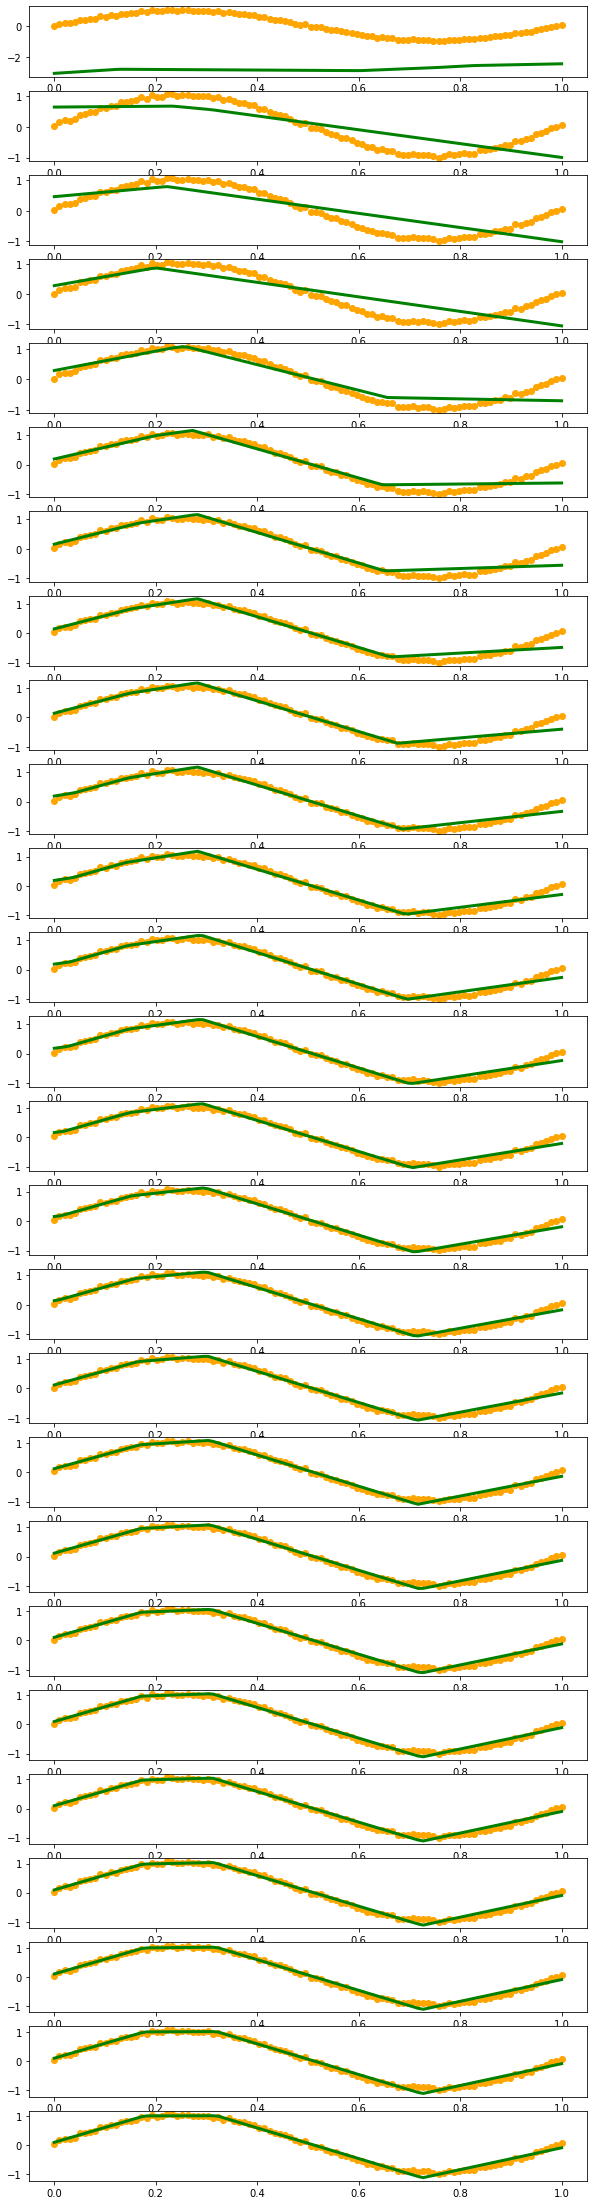

In [ ]:
import matplotlib.pyplot as plt
with torch.no_grad():
  fig, axs = plt.subplots(len(ys), 1, figsize=(10, 40))
  for ax, y_ in zip(axs, ys):
    ax.scatter(X.numpy(), y.numpy(), color = "orange")
    ax.plot(X.numpy(), y_.numpy(), 'g-', lw=3)
    

## 3.3 Построение сетей при помощи `torch.nn`

In [ ]:
import torch.nn as nn

3.3.1 Решить задачу регрессии, соблюдая следующие условия:

1. Оформить нейронную сеть в виде класса - наследника `nn.Module`
2. При создании сети использовать готовые блоки из `torch.nn`: слои, функции активации, функции потерь и т.д.
3. Для оптимизации использовать любой алгоритм оптимизации из `torch.optim` 

In [ ]:
class NN(nn.Module):
  def __init__(self, hidden_neurons, output_neurons):
    super().__init__()
    self.fc1 = nn.LazyLinear(hidden_neurons)
    self.relu = nn.ReLU()
    self.fc2 = nn.LazyLinear(output_neurons)
  def forward(self, input):
    return self.fc2(self.relu(self.fc1(input)))

In [ ]:
X = torch.linspace(0, 1, 100).view(-1, 1)
y = torch.sin(2 * np.pi * X) + 0.1 * torch.rand(X.size()) 

In [ ]:
model = NN(50, 1)
optimizer = optim.Adam(model.parameters(), lr = 1e-1)
loss_fn = nn.MSELoss()
losses = []
for epo in range(100):
  optimizer.zero_grad()
  out = model(X)
  loss = loss_fn(out, y)
  loss.backward()
  optimizer.step()
  with torch.no_grad():
    losses.append(loss.detach().numpy())

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/lazy.py:178: UserWarning:

Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.



In [ ]:
px.line(losses)

3.3.2 Решить задачу регрессии, соблюдая следующие условия:

1. Оформить нейронную сеть в виде объекта `nn.Sequential`
2. При создании сети использовать готовые блоки из `torch.nn`: слои, функции активации, функции потерь и т.д.
3. Для оптимизации использовать любой алгоритм оптимизации из `torch.optim` 

In [ ]:
class NN(nn.Module):
  def __init__(self, hidden_neurons, output_neurons):
    super().__init__()
    self.layers = nn.Sequential(nn.LazyLinear(hidden_neurons),
                                 nn.ReLU(),
                                 nn.LazyLinear(output_neurons))
    
  def forward(self, input):
    return self.layers(input)

In [ ]:
X = torch.linspace(0, 1, 100).view(-1, 1)
y = torch.sin(2 * np.pi * X) + 0.1 * torch.rand(X.size()) 

In [ ]:
model = NN(50, 1)
optimizer = optim.Adam(model.parameters(), lr = 1e-1)
loss_fn = nn.MSELoss()
losses = []
for epo in range(100):
  model.train()
  optimizer.zero_grad()
  out = model(X)
  loss = loss_fn(out, y)
  loss.backward()
  optimizer.step()
  with torch.no_grad():
    losses.append(loss.detach().numpy())

In [ ]:
px.line(losses)

## 3.4. Datasets and dataloaders

In [ ]:
from torch.utils.data import Dataset, DataLoader

In [ ]:
X = torch.linspace(0, 1, 100).view(-1, 1)
y = torch.sin(2 * np.pi * X) + 0.1 * torch.rand(X.size()) 

In [ ]:
X.shape

torch.Size([100, 1])

3.4.1 Создать датасет, поставляющий данные из задачи 3.1.2. 

Создать `DataLoader` на основе этого датасета и проверить работоспособность.

Воспользовавшись результатами 3.3.1 (или 3.3.2) обучите модель, пользуясь мини-пакетным градиентным спуском с размером пакета (`batch_size`) = 10

In [ ]:
class SinDataset(Dataset):
  def __init__(self, X,y):
    self.X = X
    self.y = y

  def __len__(self):
    return self.X.shape[0]

  def __getitem__(self, idx):
    return self.X[idx], self.y[idx]

In [ ]:
train = DataLoader(SinDataset(X, y), batch_size=10, shuffle = True)
model = NN(50, 1)
optimizer = optim.Adam(model.parameters(), lr = 1e-1)
loss_fn = nn.MSELoss()
epo_losses = []
for epo in range(100):
  model.train()
  losses = []
  for batch_X, target in train:
    optimizer.zero_grad()
    out = model(batch_X)
    loss = loss_fn(out, target)
    loss.backward()
    optimizer.step()
    losses.append(loss.detach().numpy())
  epo_losses.append(np.mean(losses))

In [ ]:
px.line(epo_losses)

3.4.2 Предсказание цен алмазов

3.4.2.1 Создайте датасет на основе файла diamonds.csv. 

1. Удалите все нечисловые столбцы
2. Целевой столбец (`y`) - `price`
3. Преобразуйте данные в тензоры корректных размеров

3.4.2.2 Разбейте датасет на обучающий и тестовый датасет при помощи `torch.utils.data.random_split`.

3.4.2.3 Обучите модель для предсказания цен при помощи мини-пакетного градиентного спуска (`batch_size = 256`). 

3.4.2.4 Выведите график функции потерь в зависимости от номера эпохи (значение потерь для эпохи рассчитывайте как среднее значение ошибок на каждом батче). Проверьте качество модели на тестовой выборке. 


data: https://www.kaggle.com/datasets/shivam2503/diamonds

In [ ]:
import pandas as pd

In [ ]:
df_diamonds = pd.read_csv('diamonds.csv', index_col=0)

In [ ]:
cols = df_diamonds.dtypes[np.logical_or(df_diamonds.dtypes == np.float64, df_diamonds.dtypes == np.int64)].index
df_diamonds = df_diamonds[cols]

In [ ]:
y = torch.tensor(df_diamonds['price'].values, dtype = torch.float).reshape(-1, 1)
X = torch.tensor(df_diamonds[cols[cols != 'price']].values, dtype = torch.float)

In [ ]:
class DiamondsDataset(Dataset):
  def __init__(self, X,y):
    self.X = X
    self.y = y

  def __len__(self):
    return self.X.shape[0]

  def __getitem__(self, idx):
    return self.X[idx], self.y[idx]

In [ ]:
dataset = DiamondsDataset(X, y)
test_size = int(0.33 * dataset.__len__())
train_size = dataset.__len__() - test_size
train_dataset, test_dataset = torch.utils.data.random_split(
    dataset, 
    [train_size, test_size])
train_dataloader = DataLoader(train_dataset, batch_size=256, shuffle = True)
test_dataloader = DataLoader(test_dataset, batch_size=test_size)

In [ ]:
for X_test, y_test in test_dataloader:
  X_test = X_test
  y_test = y_test

In [ ]:
class NN(nn.Module):
  def __init__(self, hidden_neurons, output_neurons):
    super().__init__()
    self.layers = nn.Sequential(nn.LazyLinear(5*hidden_neurons),
                                 nn.ReLU(),
                                nn.LazyLinear(4*hidden_neurons),
                                 nn.ReLU(),
                                nn.LazyLinear(3*hidden_neurons),
                                 nn.ReLU(),
                                nn.LazyLinear(2*hidden_neurons),
                                 nn.ReLU(),
                                nn.LazyLinear(hidden_neurons),
                                 nn.ReLU(),
                                 nn.LazyLinear(output_neurons))
    
  def forward(self, input):
    return self.layers(input)

In [ ]:
model = NN(10, 1)
optimizer = optim.Adamax(model.parameters(), lr = 1e-2)
loss_fn = nn.MSELoss()
epo_losses = []
epo_val_losses=[]
for epo in range(30):
  model.train()
  losses = []
  for batch_X, target in train_dataloader:
    optimizer.zero_grad()
    out = model(batch_X)
    loss = loss_fn(out, target)
    loss.backward()
    optimizer.step()
    losses.append(loss.detach().numpy())
  with torch.no_grad():
    epo_val_losses.append(loss_fn(model(X_test), y_test))
  epo_losses.append(np.mean(losses))

In [ ]:
fig = go.Figure()
fig.add_trace(go.Scatter(y = epo_losses, name = 'Train Loss'))
fig.add_trace(go.Scatter(y = epo_val_losses, name = 'Test Loss'))

In [ ]:
df_diamonds.iloc[0].index

Index(['carat', 'depth', 'table', 'price', 'x', 'y', 'z'], dtype='object')

3.4.3 Модифицируйте метод `__init__` датасета из 3.4.2 таким образом, чтобы он мог принимать параметр `transform: callable`. Реализуйте класс `DropColsTransform` для удаления нечисловых данных из массива. Реализуйте класс `ToTensorTransorm` для трансформации массива в тензор.

In [ ]:
class DiamondsDataset(Dataset):
  def __init__(self, data, transform):
    self.data = data
    self.transform = transform
    # ....

  def __len__(self):
    return self.X.shape[0]

  def __getitem__(self, idx):
    # ...
    sample =self.data.loc[[idx, self.data.columns[self.data.columns != 'price']]], self.data.iloc[idx]['price']
    if self.transform:
      sample = self.transform(sample)
    return sample


In [ ]:
class DropColsTransform:
  def __init__(self, drop):
    self.drop_list = drop
  
  def __call__(self, sample):
    X, y = sample
    indexes_to_drop = X.index[self.drop_list]
    X = X.iloc[0].drop(indexes_to_drop)
    return X, y

In [ ]:
class ToTensorTransform:
  def __call__(self, sample):
    X, y = sample
    X = torch.tensor(X, dtype = float)
    y = torch.tensor(y, dtype = float)
    return X, y

In [ ]:
from torchvision import transforms

drop = DropColsTransform(drop=[1, 2])
to_tensor = ToTensorTransform()
dataset = DiamondsDataset(df_diamonds, transforms.Compose([drop, to_tensor]))
